訊號作業:**Exercise:** One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [1]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

NameError: name 'thinkdsp' is not defined

Here's a short segment:

In [3]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

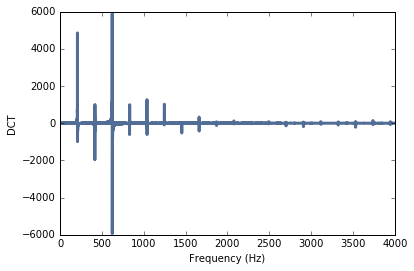

In [4]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [5]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

20457	22050	92.77551020408163


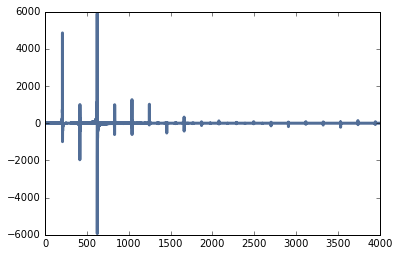

In [6]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

And the result sounds the same (at least to me):

In [7]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [8]:
def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return thinkdsp.Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [9]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

In most segments, the compression is 75-80%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [10]:
wave2 = spectro.make_wave()
wave2.make_audio()

在跟原本比較一次

In [11]:
wave.make_audio()